## Import Libraries

In [1]:
import pandas as pd
import re
import spacy

import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE

from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
import keras
from sklearn.metrics import f1_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import sklearn.metrics
import seaborn as sns

Using TensorFlow backend.


In [ ]:
pip install tensorflow


In [ ]:
# pip install keras


In [141]:
df = pd.read_csv('lyrics.csv', index_col='index')


In [3]:
#let's look at genre value counts

df.genre.value_counts()

Rock             131377
Pop               49444
Hip-Hop           33965
Not Available     29814
Metal             28408
Other             23683
Country           17286
Jazz              17147
Electronic        16205
R&B                5935
Indie              5732
Folk               3241
Name: genre, dtype: int64

In [142]:
#filter DF to four genres
genre_list = ['Rock', 'Pop', 'Country', 'Hip-Hop']


df1 = df.loc[(df['genre'] == 'Rock') | (df['genre'] == 'Pop') | (df['genre'] == 'Country') | (df['genre'] == 'Hip-Hop')]

In [143]:
#check the shape of the new dataframe
df1.shape

(232072, 5)

In [144]:
df1.isna().sum()

song          0
year          0
artist        0
genre         0
lyrics    43134
dtype: int64

In [145]:
#drop missing values from df
df1.dropna(inplace=True)


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [147]:
df1.genre.value_counts()

Rock       109235
Pop         40466
Hip-Hop     24850
Country     14387
Name: genre, dtype: int64

In [152]:
df1.lyrics.isna().sum()

0

## Cleaning Database

In [8]:
song = df1.lyrics[1]
song

"playin' everything so easy,\nit's like you seem so sure.\nstill your ways, you dont see\ni'm not sure if they're for me.\nthen things come right along our way, though we didn't truly ask.\nit seems as if they're gonna linger\nwith every delight they bring,\njust like what you have truly seemed.\ni'm trying to think of what you really want to say,\neven through my darkest day.\nyou might want to leave me,\nfeeling strange about you\nlike you're gonna let me know,\nwhen words then slipped out of you.\nwhen words dont come so easy to say\nyou just leave me feeling, come what may\nthough i want things coming from your way.\ni say to you, you bore me all the time\nwhen you seem to hold back all in you,\nall that you want to let me know.\nwhy dont you have the courage?\nspeak up and i'll listen,\nif you truly want me to know, then tell me.\nis there something wrong with you\nand you seem fastened there.\nit sounds as if there'll be a melody\nif things in you are let out\nand then i will fee

In [153]:
#replace items in brackets, and brackets themselves
df1['lyrics'] = df1['lyrics'].str.replace("[\(\[].*?[\)\]]", "", regex=True) 
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
df1['lyrics'] = df1['lyrics'].str.findall(pattern) #find alphanumeric characters
df1['lyrics'] = df1['lyrics'].str.join(' ') #join all elements back into a string
df1['lyrics'] = df1['lyrics'].str.lower()

/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [159]:
df1.reset_index(drop=True)

,song,year,artist,genre,lyrics
0,ego-remix,2009,beyonce-knowles,Pop,oh baby how you doing you know i'm gonna cut r...
1,then-tell-me,2009,beyonce-knowles,Pop,playin everything so easy it's like you seem s...
2,honesty,2009,beyonce-knowles,Pop,if you search for tenderness it isn't hard to ...
3,you-are-my-rock,2009,beyonce-knowles,Pop,oh oh oh i oh oh oh i if i wrote a book about ...
4,black-culture,2009,beyonce-knowles,Pop,party the people the people the party it's pop...
...,...,...,...,...,...
188933,who-am-i-drinking-tonight,2012,edens-edge,Country,i gotta say boy after only just a couple of da...
188934,liar,2012,edens-edge,Country,i helped you find her diamond ring you made me...
188935,last-supper,2012,edens-edge,Country,look at the couple in the corner booth looks a...
188936,christ-alone-live-in-studio,2012,edens-edge,Country,when i fly off this mortal earth and i'm measu...


0

In [163]:
#create a function that clean and tokenizes lyrics

#create a function that clean and tokenizes lyrics
def clean_tokenize_lyrics(song):
    stopwords_list = stopwords.words('english') + list(string.punctuation)
    stopwords_list += ["''", '""', '...', '``']
    word_list = []
    tokenized_lyrics = word_tokenize(song)
     #remove all tokens that are not alphabetic and stopwords
    words = [word for word in tokenized_lyrics if word not in stopwords_list and word.isalpha()]
    for word in words:
        word_list.append(word.lower())
    return word_list
    
df1['tokenize_stop_lyr'] = df1.lyrics.apply(lambda x: clean_tokenize_lyrics(x))

/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [58]:
# (df1['tokenize_stop_lyr'][0])

### Stemm Clean Lyrics

In [164]:
stemmer = SnowballStemmer('english')
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

In [165]:
df1['cleaned_lyrics_stemmed'] = df1['tokenize_stop_lyr'].apply(lambda x: [stemmer.stem(word) 
                                                for word in x if word not in stop_words])

/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Lemmantize Clean Lyrics

In [166]:
df1['cleaned_lyrics_lemm'] = df1['tokenize_stop_lyr'].apply(lambda x: [lemmatizer.lemmatize(word) 
                                            for word in x if word not in stop_words])

/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


index
0             Pop
1             Pop
2             Pop
3             Pop
4             Pop
           ...   
362232    Country
362233    Country
362234    Country
362235    Country
362236    Country
Name: genre, Length: 187507, dtype: object

In [ ]:
# df1['genre'].value_counts()

### Average Word Length

In [9]:

num_words = []
for song in df1['lyrics']:
    total_words = len(song.split())
    
    num_words.append(total_words)

In [12]:
df1['total_words'] = num_words

In [18]:
total_genre_words = df1.groupby('genre')['total_words'].mean().reset_index()

Text(0.5, 1.0, 'Average # Words per Genre')

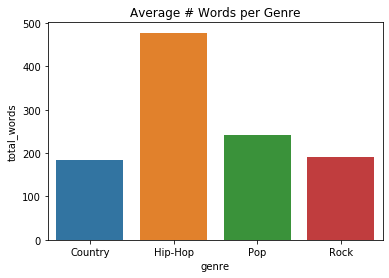

In [20]:
sns.barplot(total_genre_words['genre'], total_genre_words['total_words'])
plt.title('Average # Words per Genre')

In [168]:
#calculate proportion of unique words for each song
unique_words_proportion = []
for song in df1['cleaned_lyrics_lemm']:
    num_unique_words = len(set(song.split()))
    total_words = len(df1['lyrics'][0].split())
    unique_words_proportion.append(num_unique_words/total_words)

AttributeError: 'list' object has no attribute 'split'

In [ ]:
df1['unique_words%'] = np.array(unique_words_proportion)*100
                                                               

In [4]:
#calculate proportion of unique words per genre
genre_uniquewords = df1.groupby('genre')['unique_words%'].mean().reset_index()

Text(0.5, 1.0, 'Unique Words % per Genre')

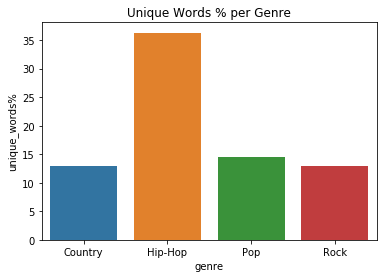

In [21]:
sns.barplot(genre_uniquewords['genre'], genre_uniquewords['unique_words%'])
plt.title('Unique Words % per Genre')

In [ ]:
df1.drop(df1[df1['lyrics'].isna() == True].index, inplace=True)

In [5]:
genre_uniquewords

,genre,unique_words%
0,Country,12.846938
1,Hip-Hop,36.293242
2,Pop,14.464954
3,Rock,12.966160


### Save Clean Database as csv file

In [2]:
# df1.to_csv('clean_lyric_df.csv')
df1 = pd.read_csv('clean_lyric_df.csv', index_col=0)

(187507, 9)

## NLP Preprocessing

### Vectorize Words

In [ ]:
#create function to vectorize song

def count_vectorize(song, vocab=None):
    if vocab:
        unique_words = vocab
    else:
        unique_words = list(set(song))
    
    song_dict = {i:0 for i in unique_words}
    
    for word in song:
        song_dict[word] += 1
    
    return song_dict

In [ ]:
BoW = count_vectorize(df1['lyrics'][0])

### Term Frequency

In [ ]:
#create term frequency function
def term_frequency(BoW_dict):
    total_word_count = sum(BoW_dict.values())
    
    for ind, val in BoW_dict.items():
        BoW_dict[ind] = val/ total_word_count
    
    return BoW_dict

In [ ]:
#create a list of dictionaries
def create_list_of_BoW(song_lyrics):

    list_of_dictionaries = []

    for song in song_lyrics:
        BoW = count_vectorize(song)

        list_of_dictionaries.append(BoW)
    return list_of_dictionaries

list_of_dictionaries = create_list_of_BoW(df1['lyrics'])

### Inverse Document Frequency

In [ ]:
def inverse_document_frequency(list_of_dicts):
    vocab_set = set()
    # Iterate through list of dfs and add index to vocab_set
    for d in list_of_dicts:
        for word in d.keys():
            vocab_set.add(word)
    
    # Once vocab set is complete, create an empty dictionary with a key for each word and value of 0.
    full_vocab_dict = {i:0 for i in vocab_set}
    
    # Loop through each word in full_vocab_dict
    for word, val in full_vocab_dict.items():
        docs = 0
        
        # Loop through list of dicts.  Each time a dictionary contains the word, increment docs by 1
        for d in list_of_dicts:
            if word in d:
                docs += 1
        
        # Now that we know denominator for equation, compute and set IDF value for word
        
        full_vocab_dict[word] = np.log((len(list_of_dicts)/ float(docs)))
    
    return full_vocab_dict

In [ ]:
inverse_document_frequency(list_of_dictionaries)

## Let's Start Modeling!!

### Importing sklean multi-class models

In [99]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report


In [76]:
#define features and target variables

features = df1['lyrics']
target = df1['genre']

In [77]:
#train test split dataset 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.25, random_state=0)

In [ ]:
#instantiate piple model
pipeline_model = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

In [ ]:
#fit training set onto model
pipeline_model.fit(X_train, y_train)


In [ ]:
y_pred = pipeline_model.predict(X_test)

In [ ]:
accuracy_score(y_pred, y_test)


In [ ]:
f1_score(y_pred, y_test, average='weighted')

#### Pipeline Results - with Stopwords
F1 score of .71 was achieved with stopwords included

### Support Vector Machine

In [78]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

In [79]:
y_pred2 = sgd.predict(X_test)
accuracy_score(y_pred2, y_test)

0.6382978723404256

In [80]:
f1_score(y_pred2, y_test, average='weighted')

/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.7513005652312277

#### SVG Results - Stopwords included
An F1 Score of .74 was achived from running an SVG model. Lyrics included stopwords and were not stemmed or lemmatized

### SVG without Stopwords

In [81]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

In [82]:
y_pred_svg = sgd.predict(X_test)
accuracy_score(y_pred_svg, y_test)

0.6382978723404256

In [83]:
f1_score(y_pred_svg, y_test, average='weighted')

/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.7513005652312277

#### SVG Results without stopwords
F1 Score is .75

### SVG with Lemmatized Words

In [30]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

In [31]:
y_pred_svg_lemm = sgd.predict(X_test)

In [32]:
f1_score(y_pred_svg_lemm, y_test, average='weighted')

/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.7484719316588461

#### SVG Results using lemmatized words
No difference in F1 Score

### Logistic Regression

In [84]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=-1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=100000.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [85]:
y_pred3 = logreg.predict(X_test)
accuracy_score(y_pred3, y_test)


0.6874351646025193

In [86]:
f1_score(y_pred3, y_test, average='weighted')

0.6945184945460425

#### Logistic Results - with Stopwords

An f1 score of .69 was achieved from this model. Lyrics included stopwords.

### Log Reg without stopwords

In [25]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=-1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=100000.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [26]:
y_pred3 = logreg.predict(X_test)
accuracy_score(y_pred3, y_test)

0.7013231713771567

In [27]:
f1_score(y_pred3, y_test, average='weighted')

0.712453447742294

#### Log Reg Results without stopwords
f1 score is .71

### XGBoost

In [186]:
vectorizor = TfidfVectorizer()

In [187]:
import xgboost as xgb

In [188]:
X = vectorizor.fit_transform(df1['lyrics'])


In [239]:
target = df1['genre']


In [240]:
#train test split dataset 
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=.25, random_state=0)

In [241]:
xgb_model = xgb.XGBClassifier(random_state=0,learning_rate=0.01)

In [242]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [243]:
xgb_pred = xgb_model.predict(X_test)

In [246]:
f1_score(xgb_pred, y_test, average='weighted')

0.7519194192917066

#### XBG Boost Results
F1 Score of .751 was achieved

In [250]:
confusion_matrix(y_test, xgb_pred)

array([[    1,     4,     1,  3653],
       [    0,  3640,    80,  2571],
       [    0,   260,   371,  9490],
       [    1,   234,   135, 26436]])

#### Confusion matrix

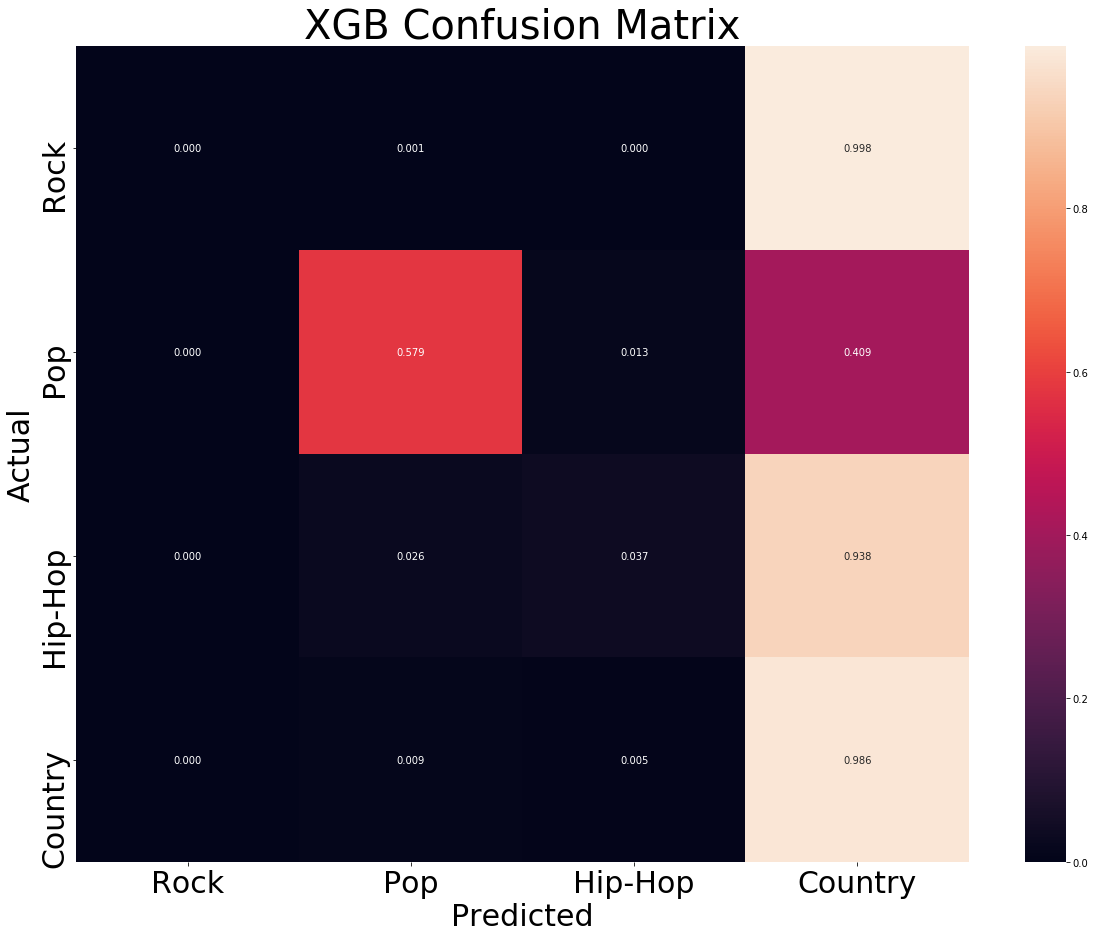

In [252]:
cm = confusion_matrix(y_test, xgb_pred) #create the confusion matrix
cm_df = pd.DataFrame(cm) #add confusion matrix
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(20,15))
ax = sns.heatmap(cmn, annot=True, fmt='.3f', xticklabels=['Rock', 'Pop','Hip-Hop','Country']\
            , yticklabels=['Rock', 'Pop','Hip-Hop','Country'])
ax.set_ylim(sorted(ax.get_xlim(), reverse=True))
plt.setp(ax.get_xticklabels(), fontsize=30)
plt.setp(ax.get_yticklabels(), fontsize=30)
plt.title('XGB Confusion Matrix', fontsize=40)
plt.ylabel('Actual', fontsize=30)
plt.xlabel('Predicted', fontsize=30)
plt.show()

In [249]:
len(xgb_pred)

46877

### Combining TFIDF with additional feature

(188938, 3)